In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import  Dataset
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import random
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import kagglehub
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import shutil
import glob
import copy
from sklearn.model_selection import KFold
import time
import torchvision.utils
from concurrent.futures import ThreadPoolExecutor
import torchvision.models as mdl
from IPython.display import clear_output

import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

writer = SummaryWriter('runs/project')

In [2]:
# Download the dataset


path_set_1 = kagglehub.dataset_download('vipoooool/new-plant-diseases-dataset')
path_set_2 = kagglehub.dataset_download('amandam1/healthy-vs-diseased-leaf-image-dataset')

path_set_1 = os.path.join(path_set_1, 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)')

print (f"Path set 1: '{path_set_1}'")
print (f"Path set 2: {path_set_2}")

Path set 1: 'C:\Users\Fabian\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
Path set 2: C:\Users\Fabian\.cache\kagglehub\datasets\amandam1\healthy-vs-diseased-leaf-image-dataset\versions\1


## Dataset Hyperparams

In [3]:
# Trainingsdata params
random_erase=0.1
scale_factor = 28
batch_size = 64
width = 224
height = 224


# Leave this on False ... 70.000 images will crash the RAM
move_to_cuda_preprocess = True


In [4]:
# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(224, padding=4),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_small = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(224, padding=4),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])


In [5]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir=".", transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        label = self.labels_df.iloc[idx, 2] if 'Labels' in self.labels_df.columns else -1
        label = np.float32(label if label == 0 or label == 1 else 0)
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
def generate_csv(root_dir, csv_path):
    data = []
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    index = 0
    num_label_0 = 0
    num_label_1 = 0

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')):
                subfolder_name = os.path.basename(subdir)
                label = 0 if subfolder_name.endswith('healthy') else 1
                if label == 0:
                    num_label_0 += 1
                else:
                    num_label_1 += 1

                # Relative path from root (./train or ./valid)
                rel_path = os.path.relpath(os.path.join(subdir, file), '.')

                data.append([index, rel_path.replace("\\", "/"), label])
                index += 1
    print(f"Number of healthy images: {num_label_0}")
    print(f"Number of diseased images: {num_label_1}")
    df = pd.DataFrame(data, columns=['Index', 'Image', 'Labels'])
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} entries to {csv_path}")

In [7]:
def split_csv(csv_path, train_csv_path, valid_csv_path, split_ratio=0.8, overwrite=False):
    df = pd.read_csv(csv_path)
    train_df = df.sample(frac=split_ratio, random_state=seed)
    valid_df = df.drop(train_df.index)

    # If train_csv_path exists, append and update index
    if os.path.exists(train_csv_path) and not overwrite:
        existing_train = pd.read_csv(train_csv_path)
        train_df = pd.concat([existing_train, train_df], ignore_index=True)
        train_df['Index'] = range(len(train_df))
    else:
        os.makedirs(os.path.dirname(train_csv_path), exist_ok=True)
        train_df['Index'] = range(len(train_df))

    # If valid_csv_path exists, append and update index
    if os.path.exists(valid_csv_path) and not overwrite:
        existing_valid = pd.read_csv(valid_csv_path)
        valid_df = pd.concat([existing_valid, valid_df], ignore_index=True)
        valid_df['Index'] = range(len(valid_df))
    else:
        valid_df['Index'] = range(len(valid_df))
        os.makedirs(os.path.dirname(valid_csv_path), exist_ok=True)

    train_df.to_csv(train_csv_path, index=False)
    valid_df.to_csv(valid_csv_path, index=False)

    print(f"Saved {len(train_df)} training entries to {train_csv_path}")
    print(f"Saved {len(valid_df)} validation entries to {valid_csv_path}")


In [8]:
def evaluate_dataset(csv_path_1, csv_path_2, model):
    
    model.eval()
    dataset1 = CustomDataset(csv_file=csv_path_1, transform=transform)
    dataset2 = CustomDataset(csv_file=csv_path_2, transform=transform)

    loader1 = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=False)
    loader2 = torch.utils.data.DataLoader(dataset2, batch_size=64, shuffle=False)

    def extract_embeddings(loader):
        embeddings = []
        with torch.no_grad():
            for images, _ in tqdm(loader, desc="Extracting embeddings"):
                images = images.to(device)
                feats = model(images)
                embeddings.append(feats.cpu())
        return torch.cat(embeddings, dim=0)

    embeddings1 = extract_embeddings(loader1)
    embeddings2 = extract_embeddings(loader2)
    min_len = min(len(embeddings1), len(embeddings2))
    embeddings1 = embeddings1[:min_len]
    embeddings2 = embeddings2[:min_len]

    def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
        # Calculate the mean and covariance difference
        diff = mu1 - mu2
        covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

        # Numerical stability
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)
        return fid

    # Convert to numpy
    embeddings1_np = embeddings1.numpy()
    embeddings2_np = embeddings2.numpy()

    # Compute mean and covariance
    mu1 = np.mean(embeddings1_np, axis=0)
    mu2 = np.mean(embeddings2_np, axis=0)
    sigma1 = np.cov(embeddings1_np, rowvar=False)
    sigma2 = np.cov(embeddings2_np, rowvar=False)

    # Calculate FID
    fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
    print("FID Score:", fid_score)

    all_embeddings = torch.cat([embeddings1, embeddings2], dim=0).numpy()
    labels = np.array([0]*len(embeddings1) + [1]*len(embeddings2))

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    plt.figure(figsize=(8,6))
    plt.scatter(embeddings_2d[labels==0,0], embeddings_2d[labels==0,1], alpha=0.5, label='Dataset 1')
    plt.scatter(embeddings_2d[labels==1,0], embeddings_2d[labels==1,1], alpha=0.5, label='Dataset 2')
    plt.legend()
    plt.title("t-SNE of Dataset Embeddings")
    plt.show()

In [9]:


# Run for both train and valid
generate_csv(os.path.join(path_set_1, './train'), 'data/train.csv')
generate_csv(os.path.join(path_set_1, './valid'), 'data/valid.csv')
generate_csv(path_set_2, 'data/dataset_2.csv')
os.makedirs('./data/evaluate', exist_ok=True)
shutil.copy('data/valid.csv', 'data/evaluate/valid.csv')
split_csv('data/dataset_2.csv', 'data/train_2.csv', 'data/test.csv')
split_csv('data/train_2.csv', 'data/train.csv', 'data/valid.csv')

df = pd.read_csv('data/train.csv')
min_count = df['Labels'].value_counts().min()

# Sample min_count from each class
df_minority = df[df['Labels'] == df['Labels'].value_counts().idxmin()]
df_majority = df[df['Labels'] == df['Labels'].value_counts().idxmax()].sample(min_count, random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_minority, df_majority]).sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced.to_csv('data/train_undersampled.csv', index=False)


Number of healthy images: 22294
Number of diseased images: 48001
Saved 70295 entries to data/train.csv
Number of healthy images: 5572
Number of diseased images: 12000
Saved 17572 entries to data/valid.csv
Number of healthy images: 2129
Number of diseased images: 2107
Saved 4236 entries to data/dataset_2.csv
Saved 30501 training entries to data/train_2.csv
Saved 7623 validation entries to data/test.csv
Saved 94696 training entries to data/train.csv
Saved 23672 validation entries to data/valid.csv


In [10]:


def process_and_save_image(idx, row, transform, output_dir):
    img_path = os.path.join('.', row['Image'])
    try:
        image = Image.open(img_path).convert('RGB')
        processed_image = transform(image)  # Tensor C,H,W
        label = row['Labels'] if not pd.isna(row['Labels']) else -1
        label = np.float32(label if label == 0 or label == 1 else 0)

        # Convert tensor back to PIL Image for saving
        to_pil = transforms.ToPILImage()
        pil_img = to_pil(processed_image)

        # Save processed image with zero-padded index filename
        out_name = f"{idx:06d}.png"
        out_path = os.path.join(output_dir, out_name)
        pil_img.save(out_path)

        return out_path, label
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None, None
    
def preprocess_and_save_images(csv_file, output_dir, output_csv, transform, num_workers=8):
    if os.path.exists(output_csv):
        print(f"Output CSV '{output_csv}' already exists. Skipping preprocessing.")
        return

    os.makedirs(output_dir, exist_ok=True)
    df = pd.read_csv(csv_file)
    processed_entries = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [
            executor.submit(process_and_save_image, idx, row, transform, output_dir)
            for idx, row in df.iterrows()
        ]

        # Wrap the futures list with tqdm, then call result() inside the loop
        for f in tqdm(futures, desc="Preprocessing & saving images"):
            out_name, label = f.result()
            if out_name is not None:
                processed_entries.append([out_name, label])

    processed_df = pd.DataFrame(processed_entries, columns=['Image', 'Labels'])
    processed_df.to_csv(output_csv, index=False)
    print(f"Saved processed images to {output_dir} and CSV to {output_csv}")


In [11]:
class NewCustomProcessedDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform):
        self.labels_df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx]['Image']
        # If saved as PNG, just load and convert to tensor
        image = Image.open(img_path)
        image = transform(image)
        #image = transforms.ToTensor()(image)  # Only if needed, otherwise remove
        label = np.float32(self.labels_df.iloc[idx]['Labels'])
        return image, label

In [12]:
class CustomProcessedDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file):
        self.labels_df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx]['Image']
        # If saved as PNG, just load and convert to tensor
        image = Image.open(img_path)
        image = image.convert('RGB')
        image = transforms.ToTensor()(image)  # Only if needed, otherwise remove
        label = np.float32(self.labels_df.iloc[idx]['Labels'])
        return image, label

In [13]:
# model = models.resnet50(pretrained=True)
# model.fc = torch.nn.Identity()
# model = model.to(device)
# evaluate_dataset('data/evaluate/valid.csv', 'data/dataset_2.csv', model)


In [14]:
# Define the dataset and data loaders
preprocess_and_save_images('data/train_undersampled.csv', 'data/processed_images/train', 'data/processed_train.csv', transform_small, num_workers=16)
preprocess_and_save_images('data/valid.csv', 'data/processed_images/valid', 'data/processed_valid.csv', transform_small, num_workers=16)

train_dataset = NewCustomProcessedDataset(csv_file='data/processed_train.csv',transform=transform)
val_dataset = NewCustomProcessedDataset(csv_file='data/processed_valid.csv',transform=transform)
test_dataset = CustomDataset(csv_file='data/test.csv', transform=transform)

Output CSV 'data/processed_train.csv' already exists. Skipping preprocessing.
Output CSV 'data/processed_valid.csv' already exists. Skipping preprocessing.


In [15]:
def get_ram_dataloader(sampler, dataset,batch_size=1, shuffle=False, num_workers=1):
    data = []
    labels = []
    for img, label in tqdm(dataset):
        data.append(img)
        labels.append(label)

    data = torch.stack(data)
    labels = torch.tensor(labels)

    #data = data.to(device)
    #labels = labels.to(device)

    loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(data, labels),
    batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=16)
    return loader

In [16]:
def get_sampler(dataset, weighted=False):
    if weighted:
        # WeightedRandomSampler against class imbalance
        labels = dataset.labels_df['Labels'].values
        class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
        weights = 1. / class_sample_count
        samples_weights = np.array([weights[int(t)] for t in labels])
        samples_weights = torch.from_numpy(samples_weights).float()

        return torch.utils.data.WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)
    else:
        return torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=len(dataset))
 

# Data loaders
train_sampler = get_sampler(train_dataset)
validation_sampler = get_sampler(val_dataset)

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=validation_sampler, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
if move_to_cuda_preprocess:
    training_loader = get_ram_dataloader(train_sampler, train_dataset, batch_size=batch_size, num_workers=16)
    validation_loader = get_ram_dataloader(validation_sampler, val_dataset, batch_size=batch_size, num_workers=16)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 21639/21639 [00:34<00:00, 635.99it/s]


# Data exploration

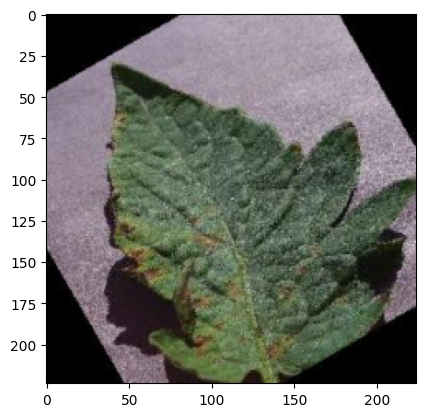

1.0
Number of samples in train_dataset: 61042
Number of samples in val_dataset_plant: 21639
Batch size: 64
Image shape (C, H, W): torch.Size([3, 224, 224])
Label example: 1.0


In [18]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataset)
next(dataiter)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in val_dataset_plant: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Image shape (C, H, W): {images.shape}")
print(f"Label example: {labels}")

Train label distribution:
Labels
0.0    30521
1.0    30521
Name: count, dtype: int64

Validation label distribution:
Labels
1.0    13950
0.0     7689
Name: count, dtype: int64


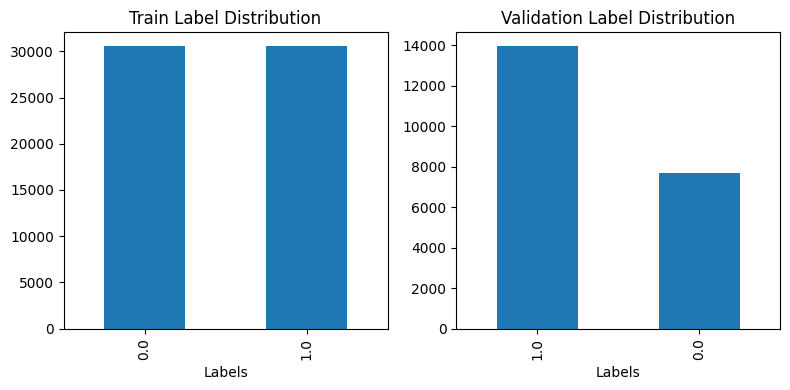

Weighted sampler batch label distribution (train):


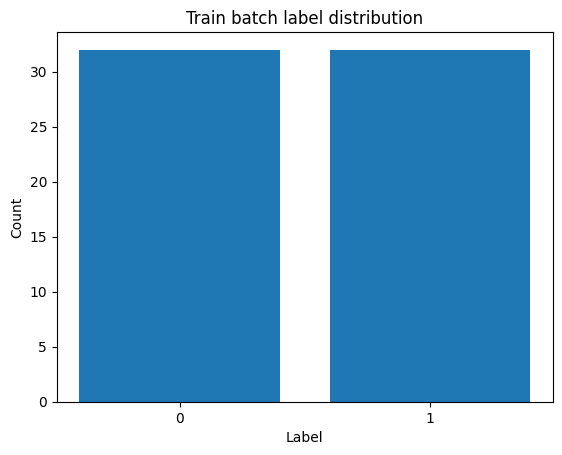

Weighted sampler batch label distribution (validation):


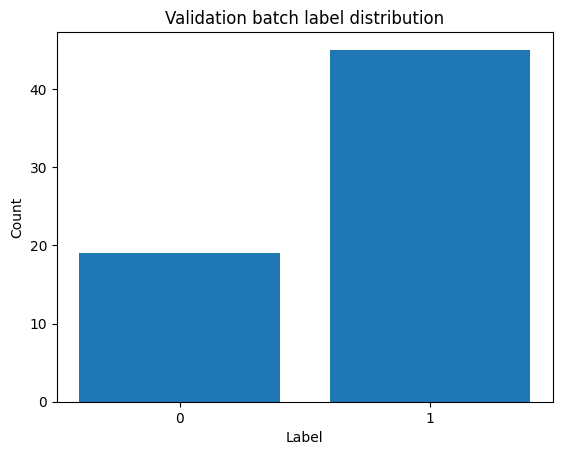

Sample image path: data/processed_images/train\000000.png
Image mode: RGB
Image size (W x H): (224, 224)
Image format: PNG
Image file size: 74.15 KB
Imbalance ratio (min/max): 1.000

Data augmentation in use:
- Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
- RandomHorizontalFlip(p=0.5)
- ToTensor()
- Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))


In [19]:
# Datenexploration: Qualität, Bitrate, Verteilung der Labels, Dimension, etc.

# Verteilung der Labels im Trainings- und Validierungsdatensatz
train_labels = train_dataset.labels_df['Labels']
val_labels = val_dataset.labels_df['Labels']

print("Train label distribution:")
print(train_labels.value_counts())
print("\nValidation label distribution:")
print(val_labels.value_counts())

# Plot label distribution
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
train_labels.value_counts().plot(kind='bar', title='Train Label Distribution')
plt.subplot(1, 2, 2)
val_labels.value_counts().plot(kind='bar', title='Validation Label Distribution')
plt.tight_layout()
plt.show()

# Show label distribution in a batch from the weighted sampler
def plot_batch_label_distribution(loader, name):
    batch_imgs, batch_labels = next(iter(loader))
    unique, counts = np.unique(batch_labels.cpu().numpy(), return_counts=True)
    plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
    plt.title(f"{name} batch label distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

print("Weighted sampler batch label distribution (train):")
plot_batch_label_distribution(training_loader, "Train")
print("Weighted sampler batch label distribution (validation):")
plot_batch_label_distribution(validation_loader, "Validation")

# Beispielbild: Qualität, Dimension, Bitrate
sample_img_path = train_dataset.labels_df.iloc[0]['Image']
sample_img = Image.open(sample_img_path)
print(f"Sample image path: {sample_img_path}")
print(f"Image mode: {sample_img.mode}")
print(f"Image size (W x H): {sample_img.size}")
print(f"Image format: {sample_img.format}")

# Bitrate (Dateigröße in KB)
img_size_kb = os.path.getsize(sample_img_path) / 1024
print(f"Image file size: {img_size_kb:.2f} KB")

# Check for class imbalance
imbalance_ratio = train_labels.value_counts().min() / train_labels.value_counts().max()
print(f"Imbalance ratio (min/max): {imbalance_ratio:.3f}")
if imbalance_ratio < 0.5:
    print("Warning: The dataset is imbalanced!")

# Data augmentation check
print("\nData augmentation in use:")
for t in transform.transforms:
    print("-", t)

## Models

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),

            nn.Conv2d(32, 32, kernel_size=15, padding=7),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),

        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32 * int(width/(2**7)) * int(height/(2**7)), 4 * int(width/(2**7)) * int(height/(2**7))),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4 * int(width/(2**7)) * int(height/(2**7)), num_classes),
            #nn.Sigmoid(),
            nn.Softmax(),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x #x.reshape(-1)



class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=1, stride=1):
        super().__init__()
        expanded_channels = int(in_channels * expansion_factor)
        hidden_channels = expanded_channels

        # Expansion convolution (skip if expansion_factor == 1)
        if expansion_factor != 1:
            self.expand = nn.Sequential(
                nn.Conv2d(in_channels, expanded_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(expanded_channels),
                nn.SiLU()
            )
        else:
            self.expand = nn.Identity()

        # Depthwise convolution
        self.depthwise = nn.Sequential(
            nn.Conv2d(expanded_channels, hidden_channels, kernel_size=3, stride=stride, padding=1, groups=hidden_channels, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.SiLU()
        )

        # Projection convolution
        self.project = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Use residual connection if possible
        self.use_residual = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        identity = x
        x = self.expand(x)
        x = self.depthwise(x)
        x = self.project(x)

        if self.use_residual:
            x = x + identity

        return x

class SmallEfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )

        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, expansion_factor=1, stride=1),
            MBConvBlock(16, 24, expansion_factor=2, stride=2),
            MBConvBlock(24, 40, expansion_factor=2, stride=2),
            MBConvBlock(40, 48, expansion_factor=2, stride=2),
            MBConvBlock(48, 48, expansion_factor=2, stride=1),
            MBConvBlock(48, 48, expansion_factor=2, stride=1),
            MBConvBlock(48, 48, expansion_factor=2, stride=1),
            MBConvBlock(48, 64, expansion_factor=2, stride=2),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x

# Verify the model
model = SmallEfficientNet()
print("Total parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Example input (224x224 RGB image)
dummy_input = torch.randn(1, 3, 224, 224)
output = model(dummy_input)
print("Output shape:", output.shape)


Total parameters: 59458
Output shape: torch.Size([1, 2])


## Training

In [21]:
def log_metrics_to_tensorboard(model_name, epoch, test_loss):
    writer.add_scalar(f'{model_name}/test_loss', test_loss, epoch)

def log_accuracy_to_tensorboard(model_name, epoch, accuracy):
    writer.add_scalar(f'{model_name}/accuracy', accuracy, epoch)

In [22]:
def build_config(model, criterion=nn.BCELoss(), learn_rate=0.0001, optim_base=optim.AdamW, epochs=150, patience=5, early_stopping=True,choose_best_loss_model=True):
    dic = {}
    dic["model"] = model#copy.deepcopy(model)
    if criterion: dic["criterion"] = criterion
    if learn_rate: dic["learn_rate"] = learn_rate
    if optim_base: dic["optim_base"] = optim_base
    if epochs: dic["epochs"] = epochs
    if early_stopping: dic["early_stopping"] = early_stopping
    if choose_best_loss_model: dic["choose_best_loss_model"] = choose_best_loss_model
    return dic 

def simple_train(model, train_loader, val_loader, criterion=nn.BCELoss(), learn_rate=0.0001, optim_base=optim.AdamW, epochs=150, patience=5, early_stopping=True,choose_best_loss_model=True):
    # Calculate the total number of parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #print(f'Total number of parameters: {total_params}')
    intro_text = f"""Training {total_params} Parameters {model._get_name()} with 
          criterion: {criterion},
          optim_base: {optim_base},
          learn_rate: {learn_rate}, 
          epochs: {epochs}, 
          patience: {patience}, 
          early_stopping: {early_stopping}, 
          choose_best_loss_model: {choose_best_loss_model}"""
    print(intro_text)
    
    print("--------")

    hash_int = hash((model._get_name(), criterion, learn_rate, optim_base, epochs, patience, early_stopping, choose_best_loss_model))
    writer.add_text(f'{model._get_name()}_{hash_int}/train_loss', intro_text)

    optimizer = optim_base(model.parameters(), lr=learn_rate)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

    # Move the model to GPU if available
    model.to(device)

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_acc = 0
    patience_counter = 0
    outer_loop = tqdm(range(epochs), desc="Epochs")
    
    for epoch in outer_loop:
        #print(f'Epoch {epoch + 1}/{epochs}')
        model.train()
        running_loss = 0.0
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            
            if (outputs.shape[1] == 2):
                labels = labels.long()
            

            outputs = outputs.squeeze(-1)

            loss = criterion(outputs, labels)

            writer.add_scalar(f'{model._get_name()}_{hash_int}/train_loss', loss.detach().item(), epoch*len(train_loader)+idx)
            running_loss += loss.detach().item()

            # Backward pass
            loss.backward()
            optimizer.step()

        #scheduler.step()
        #print(f'Training loss: {running_loss / len(train_loader)}')
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                #print(outputs.shape)
                if (outputs.shape[1] == 2):
                    labels = labels.long()

                outputs = outputs.squeeze(-1)


                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Convert the outputs to predicted class labels
                if (outputs.shape[1] == 2):
                    predicted = outputs.argmax(dim=1).float() #torch.max(outputs, 1)
                else:
                    predicted = (outputs>0.5).float() #torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total

        writer.add_scalar(f'{model._get_name()}_{hash_int}/running_loss', running_loss / len(train_loader), epoch)
        writer.add_scalar(f'{model._get_name()}_{hash_int}/val_loss', val_loss, epoch)
        writer.add_scalar(f'{model._get_name()}_{hash_int}/val_acc', val_accuracy, epoch)

        tqdm.set_description_str(outer_loop,f"Epochs: [acc: ({val_accuracy:.4f}/{best_val_acc:.4f}), loss: ({val_loss:.4f}/{best_val_loss:.4f})]")
        #print(f'Validation loss: {val_loss / len(val_loader)}')
        #print(f'Validation accuracy: {val_accuracy:.4f}')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = patience_counter - 1 if patience_counter > 0 else 0
            torch.save(model.state_dict(), 'best_acc_model.pth')
            #print(f'Best model saved with valid acc of {val_accuracy:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_val_model.pth')
            #print(f'Best model saved with valid loss of {val_loss / len(val_loader)}')
        else:
            patience_counter += 1
            if patience_counter >= patience and early_stopping:
                print("Early stopping triggered")
                break
    if (choose_best_loss_model):
        model.load_state_dict(torch.load('best_val_model.pth'))
        return model
    return model

In [23]:
def eval(model, test_loader):
    import gc
    model.to(device)

    # Make predictions on the test dataset
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for images, label in test_loader:
            images = images.to(device)
            outputs = model(images)
            if (outputs.shape[1] == 2):
                predicted = outputs.argmax(dim=1).float()
            else:
                predicted = (outputs>0.5).float()
            labels.extend(label.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            # Explicitly delete tensors to free GPU memory
            del images, label, outputs, predicted
            torch.cuda.empty_cache()
            gc.collect()

    # Create a DataFrame with IDs and predictions
    submission_df = pd.DataFrame({
        #'images': test_dataset.labels_df['Images'],
        'labels': predictions,
        'groundtruth': labels
    })

    submission_df_ones = submission_df[submission_df.groundtruth == 1]
    submission_df_zeros = submission_df[submission_df.groundtruth == 0]
    tp = (submission_df_ones.labels == submission_df_ones.groundtruth).sum()
    tn = (submission_df_zeros.labels == submission_df_zeros.groundtruth).sum()
    fn = (submission_df_ones.labels != submission_df_ones.groundtruth).sum()
    fp = (submission_df_zeros.labels != submission_df_zeros.groundtruth).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    f1 = (2*precision*recall)/(precision+recall)
    # Final cleanup after loop
    torch.cuda.empty_cache()
    gc.collect()
    return accuracy, precision, recall, f1, (tp, tn, fn, fp)

In [24]:


def simple_hyper_train(configurations):
    model_list = []
    for config in configurations: 
        config["train_loader"] = training_loader
        config["val_loader"] = validation_loader
        model = simple_train(**config)
        model_list.append(model)
    results = []
    for model in model_list:
        accuracy, precision, recall, f1, (tp, tn, fn, fp) = eval(model, test_loader)
        result = {
            "model": model,
            "accuracy": accuracy, 
            "precision": precision,
            "recall": recall, 
            "f1": f1, 
            "hidden": (tp, tn, fn, fp),
        }
        results.append(result)
    return results



In [25]:


def shortend(configs):
    conf_out = []
    for config in configs:
        d = {
            "name": config["model"]._get_name(),
            "accuracy": float(config["accuracy"]),
            "f1": float(config["f1"])
        }
        conf_out.append(d)
    return conf_out



In [26]:


def kfold_hyper_train(configs):
    k_folds = len(configs)
    kf = KFold(n_splits=k_folds, shuffle=True)

    model_list = []
    # Loop through each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}")
        print("-------")

        # Define the data loaders for the current fold
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        test_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )
        config = configs[fold]
        config["train_loader"] = train_loader
        config["val_loader"] = test_loader
        model = simple_train(**config)
        model_list.append((model, test_loader))
    results = []
    for model, loader in model_list:
        accuracy, precision, recall, f1, (tp, tn, fn, fp) = eval(model, loader)
        result = {
            "model": model,
            "accuracy": accuracy, 
            "precision": precision,
            "recall": recall, 
            "f1": f1, 
            "hidden": (tp, tn, fn, fp),
        }
        results.append(result)
    return results



In [27]:
def choose_best_config(configs):
    results = kfold_hyper_train(configs)
    results = [result["accuracy"] for result in results]
    def argmax(iterable):
        return max(enumerate(iterable), key=lambda x: x[1])[0]
    max_idx = argmax(results)
    clear_output()
    return configs[max_idx]

def build_configs(model: nn.Module):
    configs = [
        #build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.1, epochs=75),
        build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.01, epochs=40),
        build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.001, epochs=40),
        build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.0001, epochs=40),
        build_config(copy.deepcopy(model), criterion=nn.CrossEntropyLoss(), learn_rate=0.00001, epochs=40),
    ]
    return configs

def best_config(model: nn.Module):
    backup_model = copy.deepcopy(model)
    config = choose_best_config(build_configs(model))
    #config["original_model"] = config["model"]
    config["model"] = backup_model
    return config
configs = []

In [28]:
efficientnet_b0 = mdl.efficientnet_b0(weights="IMAGENET1K_V1")
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, 2)
configs.append(best_config(efficientnet_b0))

In [29]:
squeezenet1_1 = mdl.squeezenet1_1(weights="IMAGENET1K_V1")
squeezenet1_1.classifier[1] = nn.Conv2d(512, 2, kernel_size=1,stride=1)
configs.append(best_config(squeezenet1_1))

In [30]:
configs.append(best_config(SmallEfficientNet()))

In [31]:
configs.append(best_config(CNN()))
configs

[{'model': EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): Sig

In [32]:
results = simple_hyper_train(configs)
shortend(results)

Training 4010110 Parameters EfficientNet with 
          criterion: CrossEntropyLoss(),
          optim_base: <class 'torch.optim.adamw.AdamW'>,
          learn_rate: 1e-05, 
          epochs: 40, 
          patience: 5, 
          early_stopping: True, 
          choose_best_loss_model: True
--------


Epochs: [acc: (0.9991/0.9995), loss: (1.0126/0.4585)]:  68%|██████▊   | 27/40 [46:24<22:20, 103.12s/it]   


Early stopping triggered
Training 723522 Parameters SqueezeNet with 
          criterion: CrossEntropyLoss(),
          optim_base: <class 'torch.optim.adamw.AdamW'>,
          learn_rate: 1e-05, 
          epochs: 40, 
          patience: 5, 
          early_stopping: True, 
          choose_best_loss_model: True
--------


Epochs: [acc: (0.9921/0.9947), loss: (8.9392/6.2493)]:  60%|██████    | 24/40 [18:36<12:24, 46.53s/it] 


Early stopping triggered
Training 59458 Parameters SmallEfficientNet with 
          criterion: CrossEntropyLoss(),
          optim_base: <class 'torch.optim.adamw.AdamW'>,
          learn_rate: 0.001, 
          epochs: 40, 
          patience: 5, 
          early_stopping: True, 
          choose_best_loss_model: True
--------


Epochs: [acc: (0.9826/0.9841), loss: (16.7363/15.7472)]:  28%|██▊       | 11/40 [08:46<23:07, 47.86s/it]


Early stopping triggered
Training 275918 Parameters CNN with 
          criterion: CrossEntropyLoss(),
          optim_base: <class 'torch.optim.adamw.AdamW'>,
          learn_rate: 0.0001, 
          epochs: 40, 
          patience: 5, 
          early_stopping: True, 
          choose_best_loss_model: True
--------


Epochs: [acc: (0.9852/0.9896), loss: (110.9966/109.7176)]:  95%|█████████▌| 38/40 [32:41<01:43, 51.63s/it]


Early stopping triggered


[{'name': 'EfficientNet',
  'accuracy': 0.9804538895447986,
  'f1': 0.9812649314724003},
 {'name': 'SqueezeNet',
  'accuracy': 0.9645808736717828,
  'f1': 0.9657012195121951},
 {'name': 'SmallEfficientNet',
  'accuracy': 0.9410993047356684,
  'f1': 0.9429116338207247},
 {'name': 'CNN', 'accuracy': 0.9648432375705103, 'f1': 0.9661445174330471}]

In [33]:
results

[{'model': EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): Sig

In [34]:

def inference_time(model):
    image, label = val_dataset[0]
    image = image.unsqueeze(0)
    model.cpu()
    since = time.time()
    model(image)
    now = time.time()
    now - since

In [35]:
%load_ext tensorboard
%tensorboard --logdir=runs